In [ ]:
%matplotlib inline

In [ ]:
from numpy import asarray, zeros, reshape, double, arange, ma, log10, diff, mean, flipud, floor, pi, sqrt, size

In [ ]:
from IPython.html import widgets
# [widget for widget in dir(widgets) if widget.endswith('Widget')]

In [ ]:
import datetime

import matplotlib.pyplot as plt

from matplotlib.mlab import find

from PIL import Image

from scipy.signal import wiener

import os

__author__   = 'Alexander Myasoedov'
__email__    = 'mag@rshu.ru'
__created__  = datetime.datetime(2014, 10, 28)
__modified__ = datetime.datetime(2014, 5, 27)
__version__  = "1.0"
__status__   = "Development"

In [ ]:
inpath = '/media/SOLabNFS2/tmp/sentinel-1/Svalbard-Barents/'
fileNameList = ['S1A_EW_GRDH_1SDH_20141003T071321_20141003T071421_002662_002F6B_AFCF.zip',
                 'S1A_EW_GRDH_1SDH_20141003T071221_20141003T071321_002662_002F6B_0F56.zip',
                 'S1A_EW_GRDH_1SDH_20141003T071117_20141003T071221_002662_002F6B_CAFE.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061601_20141004T061701_002676_002FBD_3300.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061701_20141004T061800_002676_002FBD_EF64.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061601_20141004T061701_002676_002FBD_B433.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061357_20141004T061501_002676_002FBD_A7E4.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061701_20141004T061800_002676_002FBD_89ED.zip',
                 'S1A_EW_GRDM_1SDH_20141004T061501_20141004T061601_002676_002FBD_A842.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061501_20141004T061601_002676_002FBD_4B66.zip',
                 'S1A_EW_GRDH_1SDH_20141004T061357_20141004T061501_002676_002FBD_D530.zip',
                 'S1A_EW_GRDM_1SDH_20141003T151915_20141003T152019_002667_002F88_B77B.zip',
                 'S1A_EW_GRDM_1SDH_20141003T152119_20141003T152229_002667_002F88_1BCA.zip',
                 'S1A_EW_GRDH_1SDH_20141003T152119_20141003T152229_002667_002F88_8003.zip',
                 'S1A_EW_GRDH_1SDH_20141003T152019_20141003T152119_002667_002F88_9106.zip',
                 'S1A_EW_GRDH_1SDH_20141003T151915_20141003T152019_002667_002F88_C200.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134257_20141003T134338_002666_002F83_5FD6.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134057_20141003T134157_002666_002F83_7D9C.zip',
                 'S1A_EW_GRDH_1SDH_20141003T134157_20141003T134257_002666_002F83_30DE.zip',
                 'S1A_EW_GRDH_1SDH_20141003T133957_20141003T134057_002666_002F83_0BE7.zip']

# Liza Polar Low 2015 June 01
inpath = '/media/SOLabNFS2/tmp/sentinel-1/Liza_PL_01_June_2015/'
fileNameList = ['S1A_EW_GRDM_1SDH_20150601T173700_20150601T173804_006183_0080D9_94AD.zip',
                'S1A_EW_GRDM_1SDH_20150601T173804_20150601T173858_006183_0080D9_E1A6.zip',
                '']

# inpath = '/media/SOLabNFS2/tmp/sentinel-1/'
# fileNameList = ['S1A_IW_GRDH_1SDV_20141004T155619_20141004T155644_002682_002FE5_BE58.zip']
fn = fileNameList[-1]

In [ ]:
from readS1 import *
import readS1
reload(readS1)

In [ ]:
s1 = readS1.readS1(inpath=inpath, fn=fn)

In [ ]:
s1.__dict__['raw_counts']

In [ ]:
# get vars from s1 class
for k, v in s1.__dict__.iteritems():
    locals()[k]=v

In [ ]:
scale = 10

sigma0w = {}
roughness = {}

print "Scale set to: \'%s\' " %scale

for p in polarization:
    print "Filtering Image: \'%s\' polarization" %p
    
    # filter the image
    sigma0w[p] = wiener(sigma0[p][::scale,::scale], mysize=(7,7), noise=None)
#     sigma0w[p] = sigma0[p]

In [ ]:
# S1 Pixel resolution
# we use pxlResSAR for further GSHHS rasterizing and reprojecting data with pyresample

lonlim = (lons_2[::scale,::scale].min(),lons_2[::scale,::scale].max())
latlim = (lats_2[::scale,::scale].min(),lats_2[::scale,::scale].max())

# enlarge lonlims for cropping a bit larger area for masking
lonlimGSHHS = (lonlim[0]-1.0, lonlim[1]+1.0)
latlimGSHHS = (latlim[0]-1.0, latlim[1]+1.0)


# Get first guess pixel resolution
import distancelib
pxlResSARm  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                     lons_2[::scale,::scale], \
                                                     lons_2[::scale,::scale].shape, 'km'))*1e3
pxlResSARdeg  = asarray(distancelib.getPixelResolution(lats_2[::scale,::scale], \
                                                       lons_2[::scale,::scale], \
                                                       lons_2[::scale,::scale].shape, 'deg'))

print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)

In [ ]:
import pyresample as pr
from pyproj import Proj

# Define areas with pyresample
swath_def = pr.geometry.SwathDefinition(lons=lons_2[::scale,::scale], lats=lats_2[::scale,::scale])

area_def_4326 = swath_area_def(name='Temporal SWATH EPSG Projection 4326', proj='eqc',
                          lonlim=lonlimGSHHS, latlim=latlimGSHHS, ellps="WGS84", res=pxlResSARm)

In [ ]:
# Get the SAR pixel resolution from the area_def for further identical shapes
up    = min(latlimGSHHS)
down  = max(latlimGSHHS)
left  = min(lonlimGSHHS)
right = max(lonlimGSHHS)
area_extent_deg = (left, down, right, up)

area_extent_deg_shape = area_def_4326.shape

pxlResSARdeg = asarray( (abs(area_extent_deg[2] - area_extent_deg[0]) / float(area_extent_deg_shape[1]), \
                abs(area_extent_deg[3] - area_extent_deg[1]) / float(area_extent_deg_shape[0])) )

pxlResSARm = asarray( (area_def_4326.pixel_size_x, area_def_4326.pixel_size_y) )
print "S1 cell resolution, %s deg"  % str(pxlResSARdeg)
print "S1 cell resolution, %s m"  % str(pxlResSARm)


In [ ]:
# Apply Mask from GSHHS

import gshhs_rasterize
reload(gshhs_rasterize)

# ESRI shapefile containing land polygons
shapefile = '/media/SOLabNFS/store/auxdata/coastline/GSHHS_shp/f/GSHHS_f_L1.shp'

# reproject GSHHS onto S1 grid before calculations
print "Rasterizing Land Mask"
mask_arr_4326 = gshhs_rasterize.gshhs_rasterize_4326(lonlimGSHHS, latlimGSHHS, \
                                     pxlResSARdeg, area_def_4326.shape, True, \
                                     shapefile)

In [ ]:
mask_arr_swath = pr.kd_tree.resample_nearest(area_def_4326, mask_arr_4326, swath_def, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [ ]:
print area_def_4326.shape, mask_arr_4326.shape
print mask_arr_swath.shape, sigma0w[p].shape, swath_def.shape

In [ ]:
# Nice Image (Roughness)

sigma0wAvg = {}
roughnessNrmlzd = {}

for p in polarization:
    print "Nice Image: \'%s\' polarization" %p

    roughness[p] = ma.masked_where(mask_arr_swath, sigma0w[p])

    sigma0wAvg[p] = ma.median(roughness[p], axis=0)

    roughnessNrmlzd[p] = (roughness[p]-sigma0wAvg[p])/sigma0wAvg[p]

In [ ]:
p = 'hv'

In [ ]:
plt.close('all')
plt.imshow(noiseLut_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.figure()
plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0), 'b')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e6, 'r')
plt.show()

In [ ]:
plt.close('all')
plt.semilogy( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2)/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.hold(True)
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)**2/sigmaNought_2[p][::scale,::scale].mean(axis=0) , 'r')
plt.axes()
plt.show()

In [ ]:
plt.close('all')
plt.semilogy( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 )
plt.semilogy( noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13, '--' )
plt.ylim(1e3,2e4)
plt.show()

In [ ]:
plt.close('all')
plt.imshow( 10*log10( (double(raw_counts[p][::scale,::scale])**2 - noiseLut_2[p][::scale,::scale]*1e13 )/sigmaNought_2[p][::scale,::scale]**2),
           vmin=-20, vmax=0)
plt.gray()
plt.colorbar()
plt.show()

In [ ]:
# sigma0[p] = ( double(raw_counts[p])**2 - noiseLut_2[p] )/sigmaNought_2[p]**2

plt.close('all')
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)     )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2)
plt.plot( ( double(raw_counts[p][::scale,::scale].mean(axis=0))**2 - noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13 )/sigmaNought_2[p][::scale,::scale].mean(axis=0)**2, 'k:')
# plt.plot(noiseLut_2[p][::scale,::scale].mean(axis=0)*1e13, 'r')
plt.show()

In [ ]:
# Try to split the image into several parts and normalize each part to remove the scalloping effect
# which is still visible even after ESA applies the TOPSAR technique
# https://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/acquisition-modes/interferometric-wide-swath

In [ ]:
# From https://gist.github.com/endolith/250860

from numpy import NaN, Inf, arange, isscalar, asarray, array
 
def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
 
    return array(maxtab), array(mintab)

In [ ]:
# Find the peaks value index to split the image in several parts
# NB! We use sigma0 data for peaks not the LUTs, as the peaks in data and LUTs are a bit different, We believe the data itself, not the LUTs
# First guess number of peaks calculated from LUTs
from scipy.signal import argrelmax
nsLutIndLen = len(argrelmax(noiseLut_2[p][::scale,::scale].mean(axis=0), order=10, mode='wrap')[0])
#  Loop is done comparing vector to some threshold value until peaks are found
for ii in xrange(1,500,2):
    maxtab = peakdet(sigma0wAvg[p], 1e-6*ii)[0]
#     print len(maxtab[:,0])
    if len(maxtab[:,0]) == nsLutIndLen:
        break
sgmPeakInd = maxtab[:,0]

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.hold(True)
plt.plot(arange(sgmPeakInd[1],sgmPeakInd[2]),sigma0wAvg[p][sgmPeakInd[1]:sgmPeakInd[2]], 'r')
plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [ ]:
rghns1 = roughness[p][0:900,sgmPeakInd[1]:sgmPeakInd[2]]
sgmAvg1 = rghns1.mean(axis=1)
rghnsNrmlzd = (rghns1.T-sgmAvg1)/sgmAvg1
rghnsNrmlzd = rghnsNrmlzd.T

In [ ]:
print argrelmax(sgmAvg1, order=30, mode='wrap')
print diff(argrelmax(sgmAvg1, order=30, mode='wrap'))
print '\n'

from scipy.signal import argrelmin
print argrelmin(sgmAvg1, order=30, mode='wrap')
print diff(argrelmin(sgmAvg1, order=30, mode='wrap'))

print mean(diff(argrelmax(sgmAvg1, order=30, mode='wrap')))
print mean(diff(argrelmin(sgmAvg1, order=30, mode='wrap'))[0,1:-1])


In [ ]:
print peakdet(sgmAvg1, 2e-4)[0][:,0]
print diff(peakdet(sgmAvg1, 2e-4)[0][:,0])
mean(diff(peakdet(sgmAvg1, 2e-4)[0][:,0]))

In [ ]:
plt.close('all')
# plt.plot(3*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]*1e6), 'k')
# plt.plot(10*log10(noiseLut_2[p][::scale,::scale][600,:]))
plt.hold(True)
plt.plot(10*log10(sigma0w[p][600,:]), 'r')
plt.plot(10*log10(sigma0w[p][600,:]-noiseLut_2[p][::scale,::scale][600,:]*1e6), 'g')
# plt.ylim((-110,-23))
plt.ylim((-37,-23))
plt.show()

In [ ]:
plt.close('all')
plt.plot(sgmAvg1)
# plt.hold(True)
# plt.plot(maxtab[:,0], maxtab[:,1], 'go')
plt.show()

In [ ]:
from scipy import fftpack

# Take the fourier transform of the image.
f1 = fftpack.fft(sgmAvg1)

# Now shift the quadrants around so that low spatial frequencies are in
# the center of the 1D fourier transformed image.
fshift = fftpack.fftshift( f1 )

# Calculate a 1D power spectrum
psd1D = abs( fshift )**2

In [ ]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.show()

In [ ]:
fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
print fftShiftInd

In [ ]:
# remove the low frequencies by masking with a rectangular window
# High Pass Filter (HPF)
# rows, cols = noiseLut_2[p][::scale,::scale].shape
# crow,ccol = rows/2 , cols/2
# fshift[crow-10:crow-9, ccol-10:ccol+10] = 0

fshiftFiltered = fshift

fftShiftInd = peakdet(psd1D, 2e-4)[0][:,0]
for i in range(0,len(fftShiftInd)/2):
    fshiftFiltered[fftShiftInd[i]]=0
for i in range(len(fftShiftInd)/2+1,len(fftShiftInd)):
    fshiftFiltered[fftShiftInd[i]]=0
    
# fshiftFiltered[fftShiftInd[0]]=0
# fshiftFiltered[fftShiftInd[1]]=0
# fshiftFiltered[fftShiftInd[3]]=0
# fshiftFiltered[fftShiftInd[4]]=0

# Calculate a 1D power spectrum
psd1DFiltered = abs( fshiftFiltered )**2

# shift back (we shifted the center before)
f_ishift = fftpack.ifftshift(fshiftFiltered)

# inverse fft to get the image back
img_back = fftpack.ifft(f_ishift)
img_back = abs(img_back)

In [ ]:
plt.close('all')
plt.plot(log10( psd1D ))
plt.hold(True)
plt.plot(log10( psd1DFiltered ))
plt.show()

In [ ]:
plt.close('all')
plt.plot(sgmAvg1)
plt.hold(True)
plt.plot(img_back, 'g--')
plt.show()

In [ ]:
plt.close('all')
plt.figure(figsize=(8,32/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(rghns1, vmin=0, vmax=0.01)
plt.gray()
plt.subplot(122)
plt.imshow(rghnsNrmlzd, vmin=-1, vmax=1)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

plt.set_cmap('bone_r')
plt.show()

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

noiseLutInd = Scatter(
        y=sigma0wAvg[p],
        mode='markers',
        marker=Marker(
            color='red',
            symbol='square'
        )
    )
data = Data([noiseLutInd])

# (3) Make Figure object
fig = Figure(data=data)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='noiseLutInd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [ ]:
import plotly.plotly as py
from plotly.graph_objs import *
py.sign_in('magican', '5di4fue0lf')

data = Data([
    Heatmap(
        z=flipud(roughnessNrmlzd['hh'][::10,::10]),
        colorscale='Greys',
        zauto=False,
        zmin=-1,
        zmax=1
    )
])

layout = Layout(
    autosize=True,
#     autosize=False,
#     width=roughnessNrmlzd['hh'].shape[1]/3,
#     height=roughnessNrmlzd['hh'].shape[0]/3,
)

# (3) Make Figure object
fig = Figure(data=data, layout=layout)

# (@) Send to Plotly and show in notebook
py.iplot(fig, filename='roughnessNrmlzd')
# plot_url = py.plot(fig, filename='noiseLutInd')

In [28]:
# %matplotlib inline

def ntrctv_imshow(p = 'hh', vmi=-1., vma=1., cmap='Greys'):
    plt.figure(figsize=(8,8*double(data[p].shape[0])/double(data[p].shape[1])))
    plt.imshow(data[p], vmin=vmi, vmax=vma)
    plt.colorbar()
    plt.set_cmap(cmap)

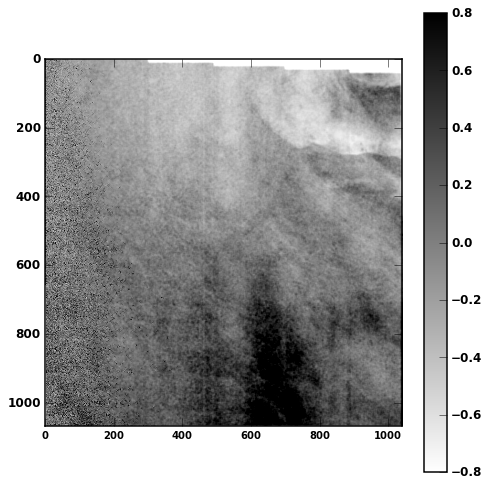

In [29]:
data=roughnessNrmlzd.copy()

ntrctv = widgets.interact(ntrctv_imshow, p = widgets.RadioButtons(description='polarization', options=data.keys()), \
                 vmi=widgets.FloatSliderWidget(min=-2, max=2, value=-1, step=0.1), \
                 vma=widgets.FloatSliderWidget(min=-2, max=2, value=1., step=0.1), \
                cmap = ['binary', 'Blues', 'BuGn', 'BuPu', 'gist_yarg',
                             'GnBu', 'Greens', 'Greys', 'Oranges', 'OrRd',
                             'PuBu', 'PuBuGn', 'PuRd', 'Purples', 'RdPu',
                             'Reds', 'YlGn', 'YlGnBu', 'YlOrBr', 'YlOrRd']);

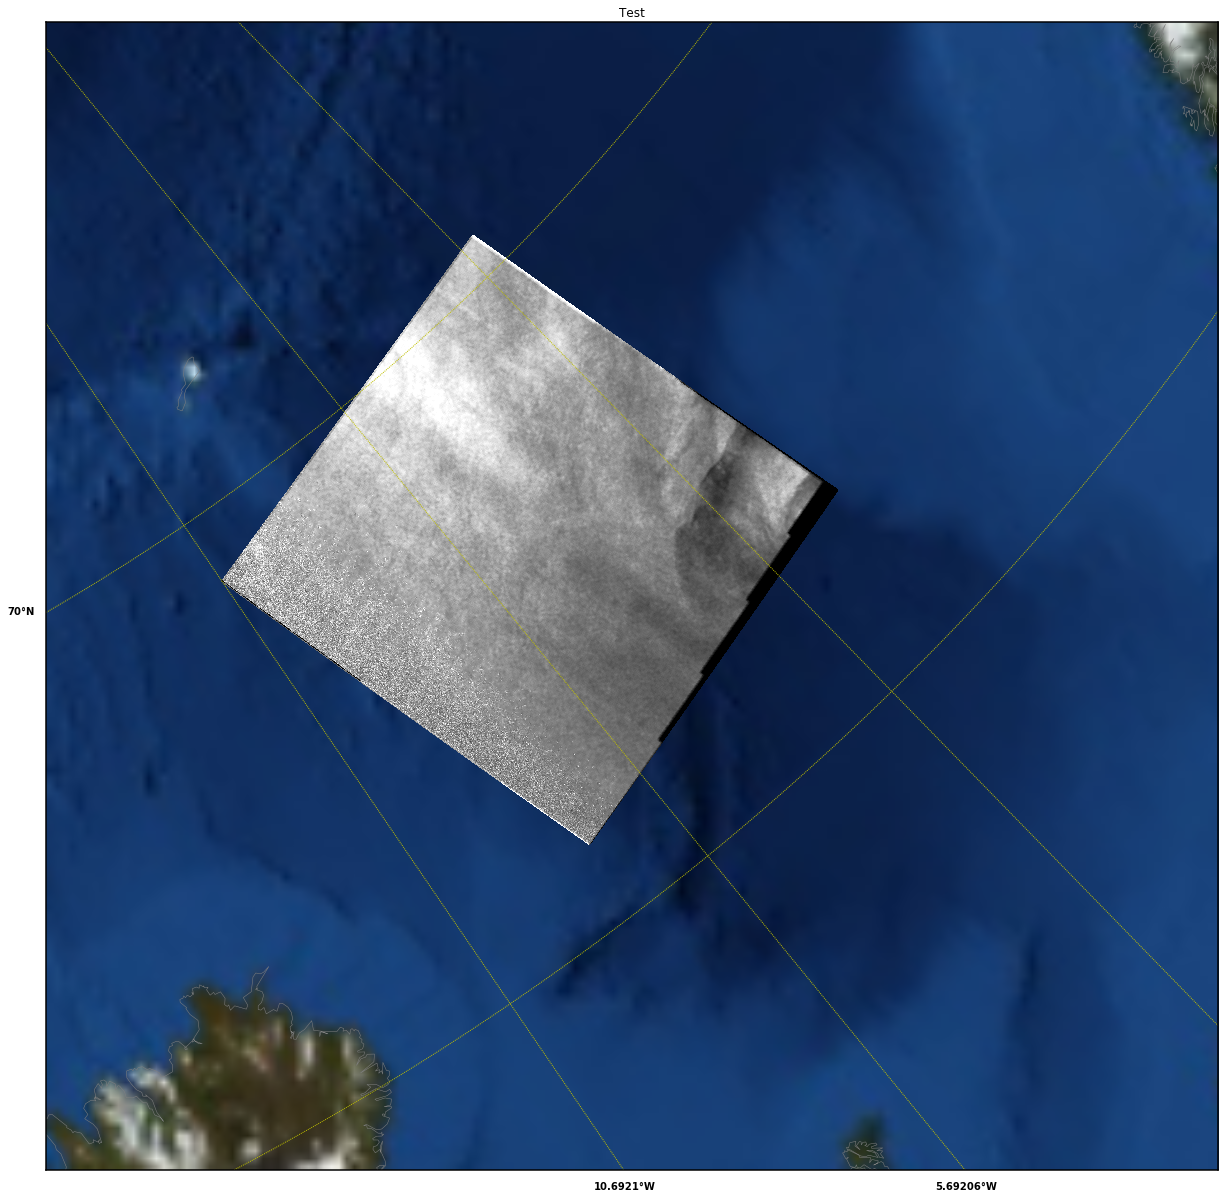

In [61]:
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

plt.close('all')
plt.figure(figsize=(21,21*double(data[p].shape[0])/double(data[p].shape[1])))
lat_ts=70.0
lat_0=90.0
lon_0=-45

# width=7000000.
# height=7000000.
# m = Basemap(width=width,height=height,resolution='l',\
#             projection='stere',lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

# Lat/Lon coords of image corners
ll_lat = lats_2.min()
ur_lat = lats_2.max()-4
ll_lon = lons_2.min()-10
ur_lon = lons_2.max()+13
cent_lat = lats_2.mean()
cent_lon = lons_2.mean()
m = Basemap(llcrnrlat=ll_lat, urcrnrlat=ur_lat,\
            llcrnrlon=ll_lon, urcrnrlon=ur_lon, \
            resolution='i', projection='stere', \
            lat_ts=lat_ts,lat_0=lat_0,lon_0=lon_0)

m.bluemarble()

x,y=m(lons_2[::scale,::scale],lats_2[::scale,::scale])
CS=m.pcolormesh(x,y,roughnessNrmlzd['hh'],cmap=cm.Greys_r, vmin=-1, vmax=1)#,ps,cmap=cm.jet,extend='max')

m.drawmeridians(arange(lonlim[0],lonlim[1],5),labels=[0,0,0,1],color='y')
m.drawparallels(arange(0,80,5),labels=[1,0,0,0],color='y')
m.drawcoastlines(linewidth=0.5,color='0.5')
plt.title('Test')

In [ ]:
import sys
sys.getsizeof(sigma0[p])

In [ ]:
s1 = sigma0[p]

In [ ]:
import numpy as np
s1

In [ ]:
np.int8(s1).nbytes

In [ ]:
plt.close('all')
plt.imshow(incidenceAngle_2[p][::scale,::scale])

In [ ]:
plt.close('all')
plt.plot(sigma0wAvg[p])
plt.plot(sigma0w[p].mean(axis=0), 'g')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,12))
plt.imshow(roughness[p], vmin=0, vmax=0.01)
# plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
# plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(roughness[p], vmin=0, vmax=0.1)
plt.gray()
plt.colorbar()
plt.title(p)
plt.subplot(122)
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
plt.gray()
plt.colorbar()
plt.title(p + ' Nrmlzd')

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16))
plt.imshow(roughnessNrmlzd[p], vmin=-1, vmax=1)
# plt.set_cmap('bone_r')
# plt.set_cmap('seismic')
plt.set_cmap('RdBu_r')


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(131)
plt.imshow(10*log10(sigma0w[polarization[0]]), vmin=-20, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[0])
plt.subplot(132)
plt.imshow(10*log10(sigma0w[polarization[1]]), vmin=-30, vmax=5)
plt.gray()
plt.colorbar()
plt.title(polarization[1])
# plt.subplot(133)
# plt.imshow(roughness[polarization[0]][::scale,::scale], vmin=0, vmax=roughness[polarization[0]].mean())
# plt.gray()
# plt.colorbar()
# plt.title(polarization[0])

In [ ]:
# Adding Model wind

startTime = datetime.datetime.strptime(\
                              manifest['xfdu:XFDU']['metadataSection']['metadataObject'][12]\
                              ['metadataWrap']['xmlData']['safe:acquisitionPeriod']['safe:startTime'],\
                              "%Y-%m-%dT%H:%M:%S.%f")

ncepGFSmodelWind = ncepGFSmodel(startTime, lats_2, lons_2)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(ncepGFSmodelWind['wind_speed'])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(ncepGFSmodelWind['wind_dir'])
plt.jet()
plt.colorbar()


In [ ]:
# plt.close('all')
# plt.figure(figsize=(16,4))
# plt.subplot(121)
# plt.imshow(ncepGFSmodelWind['lats_wind'])
# plt.jet()
# plt.colorbar()
# plt.subplot(122)
# plt.imshow(ncepGFSmodelWind['lons_wind'])
# plt.jet()
# plt.colorbar()

In [ ]:
# plt.close('all')
# plt.plot(ncepGFSmodelWind['lons_wind'][0,:])
# plt.plot(ncepGFSmodelWind['lats_wind'][:,0])

In [ ]:
# Reprojecting data

import distancelib

# Pixel resolution
# we use pxlResWind/pxlResSAR for further pyresample radius_of_influence and sigmas
pxlResWind = asarray(distancelib.getPixelResolution(ncepGFSmodelWind['lats_wind'], \
                                                    ncepGFSmodelWind['lons_wind'], \
                                                    ncepGFSmodelWind['lons_wind'].shape, 'km'))
# pxlResSAR  = asarray(distancelib.getPixelResolution(lats_2, lons_2, lons_2.shape, 'km'))*1e3

# Note pxlResWind is in KM, multiply by 1e3 for meters
print "S1 cell resolution, %s m"  % pxlResSARm
print "Wind cell resolution, %s km" % pxlResWind

In [ ]:
from scipy.interpolate import RectSphereBivariateSpline

def ncepGFSmodel2swath(lats, lons, data, lats_2, lons_2):

    func = RectSphereBivariateSpline(lats, lons, data)
    data_2 = func.ev(lats_2.ravel()*pi/180, \
                     lons_2.ravel()*pi/180)\
                     .reshape(lats_2.shape)
    return data_2


In [ ]:
# reproject NCEP onto S1 grid before calculations
# Using RectSphereBivariateSpline - Bivariate spline approximation over a rectangular mesh on a sphere
# as it is much more efficiant for full resolution
# as well as smoothes nicely the image

# We don't want to work with full res wind so scaling the image for about 100m resolution
# Adjust scale to get appropriate value
scale = 10

lts = flipud(ncepGFSmodelWind['lats_wind'])[:,0]*pi/180
lns = ncepGFSmodelWind['lons_wind'][0,:]*pi/180
data = flipud(ncepGFSmodelWind['wind_speed'])
data2 = flipud(ncepGFSmodelWind['wind_dir'])

lts_2 = lats_2[::scale,::scale]
lns_2 = lons_2[::scale,::scale]

wind_speed_model_swath = ncepGFSmodel2swath(lts, lns, data, lts_2, lns_2)
wind_dir_model_swath   = ncepGFSmodel2swath(lts, lns, data2, lts_2, lns_2)

del data, data2
    
pxlResWindSwath = asarray(distancelib.getPixelResolution(lts_2, \
                                                    lns_2, \
                                                    lns_2.shape, 'km'))
print "Interpolated Wind cell resolution, %s km" % pxlResWindSwath


In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath[::33,::33])
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_dir_model_swath[::33,::33])
plt.jet()
plt.colorbar()

In [ ]:
# calculate bearing from initial lats/lons for further wind calculation
# Taking initial values as bearing is more accurate after interpolation than vice versa
bearing = zeros((GEOgrid['lons'].shape[0]-1,GEOgrid['lons'].shape[1]))

for n in range(0,GEOgrid['lons'].shape[1]):
    col = ([GEOgrid['lats'][:-1,n], GEOgrid['lons'][:-1,n]], [GEOgrid['lats'][1:,n], GEOgrid['lons'][1:,n]])
    for m in range(0,GEOgrid['lons'].shape[0]-1):
        bearing[m][n] = distancelib.bearing(asarray(col[0])[:,m], asarray(col[1])[:,m])

# interpolate to raw_counts.shape
bearing_2 = imresize(bearing, wind_dir_model_swath.shape)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.imshow(bearing_2)
plt.jet()
plt.colorbar()

In [ ]:
# # Wind Speed

# windSpeed = {}

# # the C-2PO (C-band Cross-Polarized Ocean) model
# # B. Zhang and W. Perrie, Cross-polarized synthetic aperture radar:
# # A new potential measurement technique for hurricanes, Bull. Amer. Meteor. Soc., pp. 531-541, 2012.
# if 'vh' in polarization:
#     windSpeed['vh'] = (10*log10(sigma0w['vh']) + 35.652)/0.58
# if 'hv' in polarization:
#     windSpeed['hv'] = (10*log10(sigma0w['hv']) + 35.652)/0.58

# # convert the signal measured in HH into VV polarization before using a GMF from the CMOD family
# if 'hh' in polarization:
#     alpha=1 # for Sentinel Toolbox alpha=1, initially it was 0.6
#     sigma0w['hh2vv'] = sigma0w['hh']*(1+2*tan(incidenceAngle_2['hh'])**2)**2/(1+alpha*tan(incidenceAngle_2['hh'])**2)**2

# plt.close('all')
# plt.figure(figsize=(16,16/3*double(sigma0w[polarization[0]].shape[0])/double(sigma0w[polarization[0]].shape[1])))
# plt.imshow(windSpeed['vh'][::33,::33], vmin=0, vmax=20)
# plt.jet()
# plt.colorbar()

In [ ]:
scale

In [ ]:
#NB! WINDDIR = 0 WHEN WIND BLOWS TOWARDS RADAR!
wind_dir_model_swath_rel = 90 + bearing_2 - wind_dir_model_swath
try:
    from cmod_gpu import rcs2windOpenCl
    wind_speed_asar = rcs2windOpenCl(sar=sigma0w[p], \
                                     windir=wind_dir_model_swath_rel, \
                                     theta=incidenceAngle_2[p][::scale,::scale])
except Exception:
    from cmod_vect import rcs2windPar
    wind_speed_asar = rcs2windPar(sigma0w[p], cmdv=5, \
                                  windir=wind_dir_model_swath_rel, \
                                  theta=incidenceAngle_2[p][::scale,::scale], nprocs=numProcs)

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[500,:])
plt.plot(wind_speed_asar[500,:])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.plot(wind_speed_model_swath[:,1500])
plt.plot(wind_speed_asar[:,1500])

In [ ]:
plt.close('all')
plt.figure(figsize=(16,16/3*double(sigma0w[p].shape[0])/double(sigma0w[p].shape[1])))
plt.subplot(121)
plt.imshow(wind_speed_model_swath, vmin=3, vmax=10)
plt.jet()
plt.colorbar()
plt.subplot(122)
plt.imshow(wind_speed_asar, vmin=3, vmax=10)
plt.jet()
plt.colorbar()

In [ ]:
# Reprojecting data


roughness_4326 = pr.kd_tree.resample_nearest(swath_def, roughnessNrmlzd, area_def_4326, \
                                             radius_of_influence=4*pxlResSARm.max(), epsilon=0.5, fill_value=None)

In [ ]:
# Save png image and kml file

import simplekml

def create_KML_asar(area_extent, savepath):
    kml = simplekml.Kml()

    pol = kml.newpolygon(name='area_extent', visibility=1)
    pol.tessellate = 1

    pol.altitudemode = 'clampToGround'
    pol.outerboundaryis.coords = [(area_extent[0], area_extent[1]), (area_extent[2], area_extent[3])]
    if type(savepath) == list:
        for _savepath in savepath:
            kml.save(_savepath)
    else:
        kml.save(savepath)

oPath = '/home/mag/tmp/'
oFileName = os.path.join(oPath, fn+'.png')

close('all')
gray()
imsave(oFileName, roughness_masked, vmin=0, vmax=2)
create_KML_asar(area_def.area_extent, os.path.join(oPath, fn+'.kml'))

In [ ]:
# Generate tiles

import gdal
import sys
sys.path.append('/usr/bin')
from gdal2tiles import GDAL2Tiles

def create_asar_tiles(png_filename, tiles_output_dir, proj):
    local_argv = ['/usr/bin/gdal2tiles.py', '-p', 'raster', '-r', 'cubic',
                  '-s', proj, png_filename, tiles_output_dir]
    argv = gdal.GeneralCmdLineProcessor(local_argv)
    if argv:
        gdal2tiles = GDAL2Tiles(argv[1:])
        gdal2tiles.process()

create_KML_asar(area_def.area_extent, os.path.join(_path, fileName+'.kml'))

tiles_3413_output_dir = os.path.join(oPath, 'tiles')
png_3413_filename = oFileName
create_asar_tiles(png_3413_filename, tiles_3413_output_dir, 'EPSG:3413')

In [ ]:
# Check the lat/lon/incidenceAngle after interpolation

print diff([GEOgrid['incidenceAngle'].min(),incidenceAngle_2.min()])
print diff([GEOgrid['incidenceAngle'].max(),incidenceAngle_2.max()])

print diff([GEOgrid['lats'].min(),lats_2.min()])
print diff([GEOgrid['lats'].max(), lats_2.max()])

print diff([GEOgrid['lons'].min(), lons_2.min()])
print diff([GEOgrid['lons'].max(), lons_2.max()])

plt.close('all')
plt.figure(figsize=(16,14))

plt.subplot(321)
plt.plot(range(0,raw_counts.shape[1]), lats_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['lats'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), lats_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['lats'][-1,:], 'k.')

plt.subplot(322)
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['lats'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), lats_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['lats'][:,-1], 'k.')

plt.subplot(323)
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[0,:])
plt.plot(GEOgrid['pixel'][0,:], GEOgrid['incidenceAngle'][0,:], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[1]), incidenceAngle_2[-1,:])
plt.plot(GEOgrid['pixel'][-1,:], GEOgrid['incidenceAngle'][-1,:], 'k.')

plt.subplot(324)
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,0])
plt.plot(GEOgrid['line'][:,0], GEOgrid['incidenceAngle'][:,0], 'r.')
plt.hold
plt.plot(range(0,raw_counts.shape[0]), incidenceAngle_2[:,-1])
plt.plot(GEOgrid['line'][:,-1], GEOgrid['incidenceAngle'][:,-1], 'k.')

plt.subplot(325)
plt.plot(range(0,raw_counts.shape[1]), sigmaNought_2[0,:])
plt.plot(cLUTs['pixel'][0,::10], cLUTs['sigmaNought'][0,::10], 'r.')

plt.subplot(326)
plt.plot(range(0,raw_counts.shape[0]), sigmaNought_2[:,0])
plt.plot(cLUTs['line'][:,0], cLUTs['sigmaNought'][:,0], 'r.')

In [ ]:
lats_2[5465,10215], lons_2[5465,10215], incidenceAngle_2[p][5465,10215], sigma0[p][5465,10215]

In [ ]:
print arcsin((4.740000e+02/6.666194e+02)**2)*180/pi, incidenceAngle_2[p][0,0]
print arcsin((4.740000e+02/5.596816e+02)**2)*180/pi, incidenceAngle_2[p][-1,-1]

In [ ]:
from osgeo import gdal

ds = gdal.Open(inpath + fileLocation['s1aiwgrd' + polarization])
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/data/data/OTHER/RS2 Agulhas and Lion/RS2_SQA_1xQGSS20091224_164846_00000004/imagery_HV.tif')
ds.RasterCount

In [ ]:
ds = gdal.Open('/media/SOLabNFS2/tmp/sentinel-1/S1A_IW_SLC__1SDV_20141003T151001_20141003T151028_002667_002F87_7088.SAFE/measurement/s1a-iw1-slc-vv-20141003t151002-20141003t151027-002667-002f87-004.tiff')
slc = ds.ReadAsArray()
slc.dtype
del slc

In [ ]:
# ----------------------------------
# from scipy.interpolate import griddata
# from numpy import meshgrid, linspace

# Slant Range, Single-Look Complex (SLC) products
# are images in the slant range by azimuth imaging plane,
# in the image plane of satellite data acquisition.
# THAT MEANS that they must be interpolated more carefully using slantRangeTime and azimuthTime as in ASAR

# create new grid of raw_counts shape
# line_2, pixel_2 = meshgrid(linspace(0, lats.shape[0], raw_counts.shape[0]), linspace(0, lats.shape[1], raw_counts.shape[1]))
# Interpolate onto a new grid
# lats_2 = griddata((line.ravel(), pixel.ravel()), lats.ravel(), (line_2, pixel_2), method='cubic')
# lons_2 = griddata((line.ravel(), pixel.ravel()), lons.ravel(), (line_2, pixel_2), method='cubic')


In [ ]:
#     # Nice Image (Roughness)
#     if p == 'hh':
#         ph = (2.20495, -14.3561e-2, 11.28e-4)
#         sigma0_hh_ref = exp( ( ph[0]+incidenceAngle_2[p]*ph[1]+incidenceAngle_2[p]**2*ph[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_hh_ref
#     elif p == 'vv':
#         pv = (2.29373, -15.393e-2, 15.1762e-4)
#         sigma0_vv_ref = exp( ( pv[0]+incidenceAngle_2[p]*pv[1]+incidenceAngle_2[p]**2*pv[2])*log(10) )
#         roughness[p] = sigma0w[p]/sigma0_vv_ref